In [1]:
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
import cv2, numpy as np
import pandas as pd


Using TensorFlow backend.


In [2]:
''' basic package '''
import os
# 告訴系統要第幾張卡被看到。 Ex. 硬體總共有8張顯卡，以下設定只讓系統看到第1張顯卡
# 若沒設定，則 Tensorflow 在運行時，預設會把所有卡都佔用
# 要看裝置內顯卡數量及目前狀態的話，請在終端機內輸入 "nvidia-smi"
# 若你的裝置只有一張顯卡可以使用，可以忽略此設定
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [3]:
train_path = "/data/examples/may_the_4_be_with_u/where_am_i/train"
test_path = "/data/examples/may_the_4_be_with_u/where_am_i/testset"

In [4]:
img_cat = pd.read_csv("/data/examples/may_the_4_be_with_u/where_am_i/mid_term_mapping.txt", 
                      encoding="utf-8", header=None)
img_cat.columns = ["dirs","class"]
img_cat #class: 0~14 共15類

,dirs,class
0,CALsuburb,9
1,PARoffice,7
2,bedroom,12
3,coast,10
4,forest,4
5,highway,14
6,industrial,2
7,insidecity,3
8,kitchen,0
9,livingroom,5


In [5]:
import os

train_img_files = pd.DataFrame(columns=["dirs","files","class"])

for index, row in img_cat.iterrows():
    #print(row['dirs'], row['class'])
    for _root, _dirs, _files in os.walk(train_path+"/"+row['dirs']):
        temp = pd.DataFrame({ 'dirs':row['dirs'], 'files': _files, 'class':row['class']})
        train_img_files = pd.concat([train_img_files, temp], axis=0)

train_img_files.head(3)

,class,dirs,files
0,9.0,CALsuburb,image_0141.jpg
1,9.0,CALsuburb,image_0117.jpg
2,9.0,CALsuburb,image_0016.jpg


In [6]:
len(train_img_files)

2985

In [7]:
train_img_files = train_img_files.reset_index(drop=True)

In [8]:
import os

test_img_files = []

for _root, _dirs, _files in os.walk(test_path):
    test_img_files = _files
    
test_img_files[0:3]

['7dc74b51e229d841272c0795cffed857d0e6038a4be0c9fe51bce09b7bcb1cac.jpg',
 '1b1940d44fe4f5b76e89f876de3d2514a51b50057cae3e7ace84d3299aeaecbf.jpg',
 '7cb3479dac3e7dcc69241f4cd957380a48399b1aa0480db310f55dfc40a18960.jpg']

In [9]:
len(test_img_files)

1500

In [10]:
from keras.preprocessing import image

IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_CHANNELS = 3
ttl_train_imgs = len(train_img_files)
ttl_test_imgs = len(test_img_files)

train_X = np.zeros((ttl_train_imgs, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
test_X = np.zeros((ttl_test_imgs, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

In [11]:
from keras.applications.vgg19 import preprocess_input

for index, row in train_img_files.iterrows():
    img = image.load_img(train_path+"/"+row['dirs']+"/"+row['files'], target_size=(IMG_WIDTH, IMG_HEIGHT)) # for vgg input size: 224 x 224
    temp = image.img_to_array(img)
    temp = np.expand_dims(temp, axis=0)
    train_X[index] = preprocess_input(temp)
    img.close()
    
len(train_X)

2985

In [12]:
for index in range(len(test_img_files)):
    img = image.load_img(test_path+"/"+test_img_files[index], target_size=(IMG_WIDTH, IMG_HEIGHT)) # for vgg input size: 224 x 224
    temp = image.img_to_array(img)
    temp = np.expand_dims(temp, axis=0)
    test_X[index] = preprocess_input(temp)
    img.close()
    
len(test_X)

1500

In [13]:
import gc
del temp
gc.collect()

198

In [14]:
train_X = train_X.astype('float32') / 255.0
test_X = test_X.astype('float32') / 255.0

In [15]:
train_X[:,:,0] = (train_X[:,:,0]-train_X[:,:,0].mean())/train_X[:,:,0].std()
train_X[:,:,1] = (train_X[:,:,1]-train_X[:,:,1].mean())/train_X[:,:,1].std()
train_X[:,:,2] = (train_X[:,:,2]-train_X[:,:,2].mean())/train_X[:,:,2].std()

test_X[:,:,0] = (test_X[:,:,0]-test_X[:,:,0].mean())/test_X[:,:,0].std()
test_X[:,:,1] = (test_X[:,:,1]-test_X[:,:,1].mean())/test_X[:,:,1].std()
test_X[:,:,2] = (test_X[:,:,2]-test_X[:,:,2].mean())/test_X[:,:,2].std()

In [16]:
X_img_train_normalize = train_X
X_img_test_normalize = test_X

In [17]:
from keras.utils import np_utils
y_label_train_OneHot = np_utils.to_categorical(train_img_files["class"].astype('int'))
y_label_train_OneHot.shape

(2985, 15)

### build model

In [19]:
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from keras.layers import Input, Flatten, Dense, Dropout
from keras.models import Model
import numpy as np

In [20]:
model_vgg19_conv = VGG19(weights='imagenet', include_top=False, classes=15)
model_vgg19_conv.summary()

80142336/80134624 [==============================] - 22s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_poo

In [21]:
#Create your own input format (here 224x224x3)
input = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),name = 'image_input')

In [22]:
#Use the generated model 
output_vgg19_conv = model_vgg19_conv(input)

In [23]:
#Add the fully-connected layers 
x = Flatten(name='flatten')(output_vgg19_conv)
x = Dense(512, activation='relu', name='fc1')(x)
x = Dense(256, activation='relu', name='fc2')(x)
x = Dense(15, activation='softmax', name='predictions')(x)

In [24]:
#Create your own model 
my_model = Model(input=input, output=x)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("pr...)`
  


In [25]:
my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 224, 224, 3)       0         
_________________________________________________________________
vgg19 (Model)                multiple                  20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 512)               12845568  
_________________________________________________________________
fc2 (Dense)                  (None, 256)               131328    
_________________________________________________________________
predictions (Dense)          (None, 15)                3855      
Total params: 33,005,135
Trainable params: 33,005,135
Non-trainable params: 0
________________________________________________________________

### training model

In [26]:
from keras.models import optimizers

#, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0
opt_adam = optimizers.Adam( lr=0.001, beta_1=0.9, beta_2=0.99999, decay=0.0001 )

In [27]:
my_model.compile(loss='categorical_crossentropy', optimizer= opt_adam, metrics=['accuracy'])

In [28]:
from keras.preprocessing.image import ImageDataGenerator

print('Using real-time data augmentation.')
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True)  # randomly flip images

Using real-time data augmentation.


In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X_img_train_normalize, y_label_train_OneHot, 
                                                    test_size = 0.3, random_state=100)

In [30]:
from keras.callbacks import EarlyStopping

# earlystop
earlystop = EarlyStopping(monitor='val_acc', patience=50, verbose=0)

# Fit the model on the batches generated by datagen.flow().
train_history = my_model.fit_generator(
                    datagen.flow(X_train, y_train, batch_size=32),
                    epochs=200, workers=-1,
                    validation_data=(X_test, y_test),
                    callbacks=[earlystop]
                    )

Epoch 1/200
66/66 [==============================] - 55s 838ms/step - loss: 2.8174 - acc: 0.0987 - val_loss: 2.6728 - val_acc: 0.0926
Epoch 2/200
66/66 [==============================] - 43s 650ms/step - loss: 2.6172 - acc: 0.1153 - val_loss: 2.6808 - val_acc: 0.0893
Epoch 3/200
66/66 [==============================] - 42s 641ms/step - loss: 2.5492 - acc: 0.1435 - val_loss: 2.4234 - val_acc: 0.2009
Epoch 4/200
66/66 [==============================] - 43s 658ms/step - loss: 2.3214 - acc: 0.2347 - val_loss: 2.2646 - val_acc: 0.2723
Epoch 5/200
66/66 [==============================] - 43s 655ms/step - loss: 2.2758 - acc: 0.2498 - val_loss: 2.3045 - val_acc: 0.2478
Epoch 6/200
66/66 [==============================] - 43s 657ms/step - loss: 2.1150 - acc: 0.2903 - val_loss: 2.1402 - val_acc: 0.2935
Epoch 7/200
66/66 [==============================] - 42s 643ms/step - loss: 2.0598 - acc: 0.3024 - val_loss: 2.0574 - val_acc: 0.3382
Epoch 8/200
66/66 [==============================] - 43s 648ms

In [31]:
import matplotlib.pyplot as plt
def show_train_history(train_token,test_token):
    plt.plot(train_history.history[train_token])
    plt.plot(train_history.history[test_token])
    plt.title('Train History')
    #plt.ylabel('Accuracy')
    plt.ylabel(train_token)
    plt.xlabel('Epoch')
    plt.legend([train_token, test_token], loc='upper left')
    plt.show()

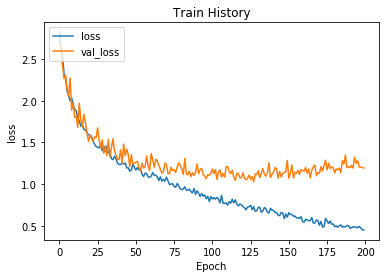

In [32]:
show_train_history('loss','val_loss')

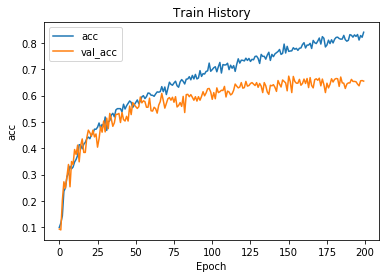

In [33]:
show_train_history('acc','val_acc')

In [34]:
scores = my_model.evaluate(X_img_train_normalize, y_label_train_OneHot, verbose=0)
scores

[0.55067741571109696, 0.82345058628462464]

In [35]:
pred_train=my_model.predict(X_img_train_normalize)

In [36]:
prediction_train = np.empty(len(pred_train))
for i in range(pred_train.shape[0]):
    prediction_train[i] = np.argmax(pred_train[i])

In [37]:
train_img_files["class"].astype('int').reshape(-1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


array([ 9,  9,  9, ..., 13, 13, 13])

In [38]:
import pandas as pd

pd.crosstab(train_img_files["class"].astype('int').reshape(-1),prediction_train,
            rownames=['class'],colnames=['predict'])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until


predict,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0
class,,,,,,,,,,,,,,,
0,85,0,0,6,0,12,0,2,0,0,0,3,2,0,0
1,0,180,3,4,0,1,0,0,0,1,0,1,0,2,0
2,0,2,149,12,0,10,0,1,3,1,0,20,0,12,1
3,3,4,0,174,0,5,0,1,0,3,1,16,0,1,0
4,0,0,0,0,218,0,1,0,6,0,0,0,0,3,0
5,10,1,4,10,0,130,0,2,0,1,0,22,8,1,0
6,0,1,1,2,4,0,238,0,21,1,37,0,0,0,5
7,29,0,0,1,0,14,0,60,0,0,0,2,8,1,0
8,0,0,6,0,8,0,23,0,227,1,3,1,0,4,1


In [39]:
pred=my_model.predict(X_img_test_normalize)

In [40]:
pred[0]

array([  5.63765760e-04,   7.36021949e-03,   4.05607857e-02,
         1.14499859e-03,   4.21267828e-07,   5.74365318e-01,
         3.56340638e-06,   1.05790030e-04,   1.41352662e-04,
         2.26507359e-03,   5.33056550e-08,   1.15378257e-02,
         2.00325623e-01,   1.61350712e-01,   2.74529069e-04], dtype=float32)

In [41]:
prediction = np.empty(len(pred))
for i in range(pred.shape[0]):
    prediction[i] = np.argmax(pred[i])

In [42]:
prediction[0]

5.0

In [43]:
#test_img_files

In [44]:

img_sub = pd.read_csv("/data/examples/may_the_4_be_with_u/where_am_i/img-submission.csv", encoding="utf-8")
img_sub.head(2)

,id,class
0,c117693e1cf24a5232090d1548cb11d4e5ea0df65680c4...,1
1,96baacc2e97886a998807ce197574821a6dc83c227c746...,1


In [45]:
Submission = pd.DataFrame({ 'id': test_img_files, 'class': prediction }, columns=["id","class"])
Submission["class"] = Submission["class"].astype('int')
Submission.head(2)

,id,class
0,7dc74b51e229d841272c0795cffed857d0e6038a4be0c9...,5
1,1b1940d44fe4f5b76e89f876de3d2514a51b50057cae3e...,3


In [46]:
img_sub[img_sub["id"] == "3d766cf9e984b45cd7b6fa0550aaf2c33e1cc881c5036f907891cf76e0fea790"]

,id,class
1410,3d766cf9e984b45cd7b6fa0550aaf2c33e1cc881c5036f...,1


In [47]:
Submission[Submission["id"] == "3d766cf9e984b45cd7b6fa0550aaf2c33e1cc881c5036f907891cf76e0fea790.jpg"]

,id,class
154,3d766cf9e984b45cd7b6fa0550aaf2c33e1cc881c5036f...,0


In [48]:
Submission["id"] = Submission["id"].apply(lambda x: x.replace(".jpg", ""))

In [49]:
Submission[Submission["id"] == "3d766cf9e984b45cd7b6fa0550aaf2c33e1cc881c5036f907891cf76e0fea790"]

,id,class
154,3d766cf9e984b45cd7b6fa0550aaf2c33e1cc881c5036f...,0


In [50]:
_test = img_sub.merge(Submission, left_on='id', right_on='id', how='outer')

In [51]:
_test.head(3)

,id,class_x,class_y
0,c117693e1cf24a5232090d1548cb11d4e5ea0df65680c4...,1,12
1,96baacc2e97886a998807ce197574821a6dc83c227c746...,1,14
2,f9bd26db23eb9b544ca78be79b11b4d1259e802885861d...,1,5


In [52]:
# Generate Submission File:
Submission[["id","class"]] = _test[["id","class_y"]]
Submission.to_csv("submission_vgg_e200_std.csv", index=False)

<font color="blue">儲存模型架構及權重值</font>

In [54]:
my_model.save_weights("SaveModel/VGG_Model.h5")
print("Saved model to disk")

Saved model to disk


In [55]:
model_yaml = my_model.to_yaml()
with open("SaveModel/VGG_Model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)

In [56]:
model_json = my_model.to_json()
with open("SaveModel/VGG_Model.json", "w") as json_file:
    json_file.write(model_json)